In [1]:
from omegaconf import OmegaConf
from models.softsplat import softsplat
from ldm.util import instantiate_from_config
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
import flowiz as fz
from src.train.util import *
import cv2

/home/maryam.sana/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = 'configs/uni_wrap/local_v15.yaml'
config = OmegaConf.load(path)
dataset = instantiate_from_config(config['data'])
print('DATA SET LENGTH ', len(dataset))

/home/maryam.sana/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATA SET LENGTH  683828


In [3]:
print(len(dataset.sequences), len(dataset.video_frames))

129291 683828


In [2]:
target_path = '/data2/local_datasets/vimeo_sequences/00009/0980/im3.png'
ref_path = '/data2/local_datasets/vimeo_sequences/00009/0980/r1.png'
flow_path = '/data2/local_datasets/vimeo_sequences/00009/0980/Flow/im3.flo'

image = cv2.imread(target_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ref = cv2.imread(ref_path)
ref= cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

flow = load_flo_file(flow_path)
flow = adaptive_weighted_downsample(flow, target_h=128, target_w=128)

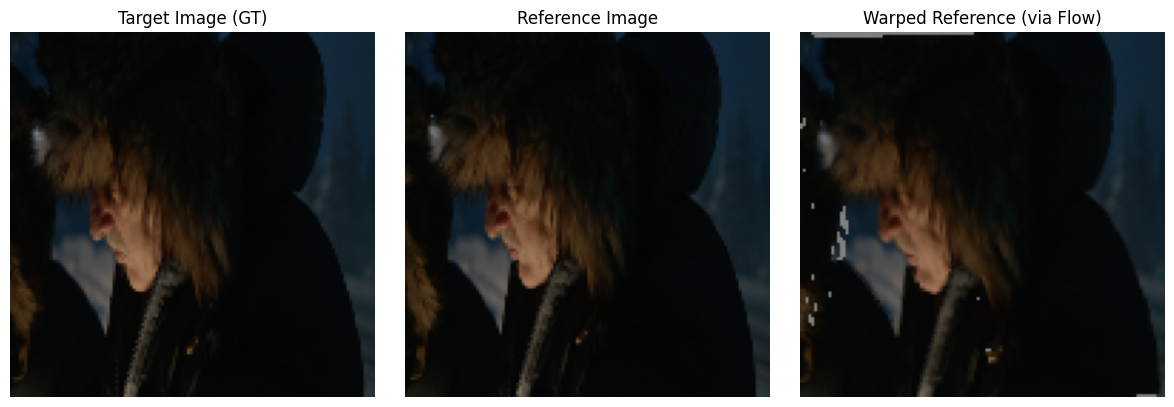

In [3]:
image_resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)
ref_resized = cv2.resize(ref, (128, 128), interpolation=cv2.INTER_LINEAR)

# --- Convert to torch tensors ---
to_tensor = transforms.ToTensor()  # Converts to [0,1], shape [C, H, W]
ref_tensor = to_tensor(ref_resized).unsqueeze(0).cuda() * 2 - 1  # [1, 3, 128, 128], [-1, 1]
image_tensor = to_tensor(image_resized).unsqueeze(0).cuda() * 2 - 1

flow_tensor = torch.from_numpy(flow).permute(2, 0, 1).unsqueeze(0).float().cuda()  # [1, 2, 128, 128]

# --- Metric mask (confidence map) — just ones for now ---
metric = torch.ones_like(ref_tensor[:, :1, :, :])

# --- Warp the reference frame using SoftSplat and flow ---
warped = softsplat(tenIn=ref_tensor, tenFlow=flow_tensor, tenMetric=metric, strMode='soft')

# --- Convert for visualization ---
image_np = ((image_tensor.squeeze().cpu() + 1) / 2).permute(1, 2, 0).numpy()
ref_np = ((ref_tensor.squeeze().cpu() + 1) / 2).permute(1, 2, 0).numpy()
warped_np = warped.squeeze().clamp(-1, 1)
warped_np = ((warped_np.cpu() + 1) / 2).permute(1, 2, 0).detach().numpy()

# --- Plot results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Target Image (GT)")
plt.imshow(image_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Reference Image")
plt.imshow(ref_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Warped Reference (via Flow)")
plt.imshow(warped_np)
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
warp_loss = F.l1_loss(torch.tensor(warped_np), torch.tensor(image_np))

In [6]:
warp_loss

tensor(0.0186)

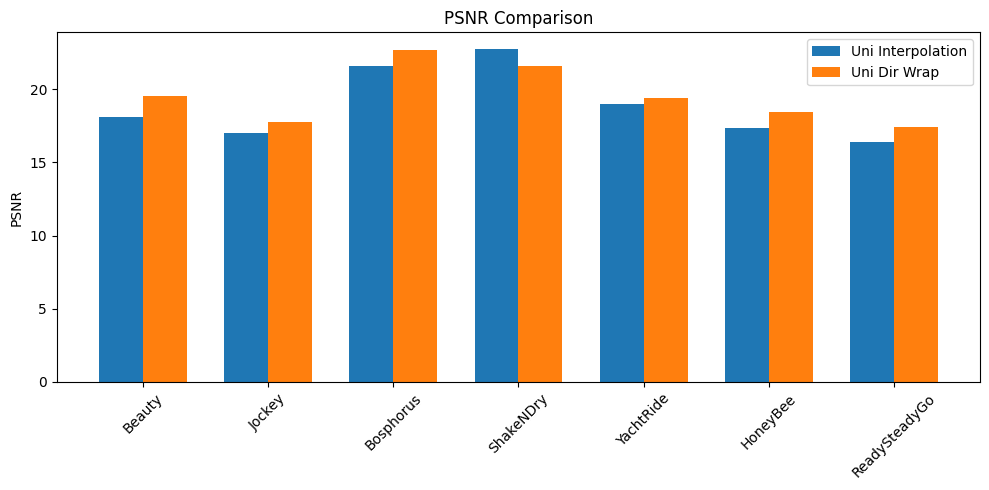

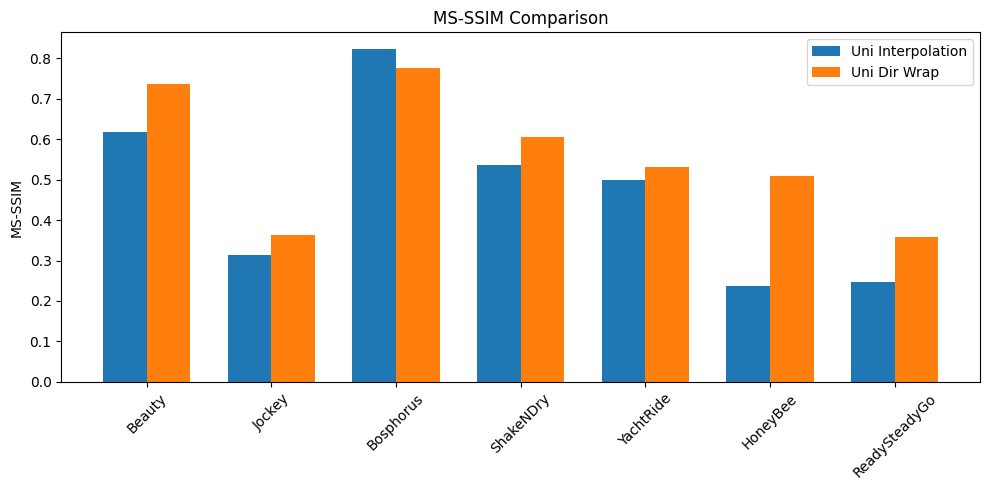

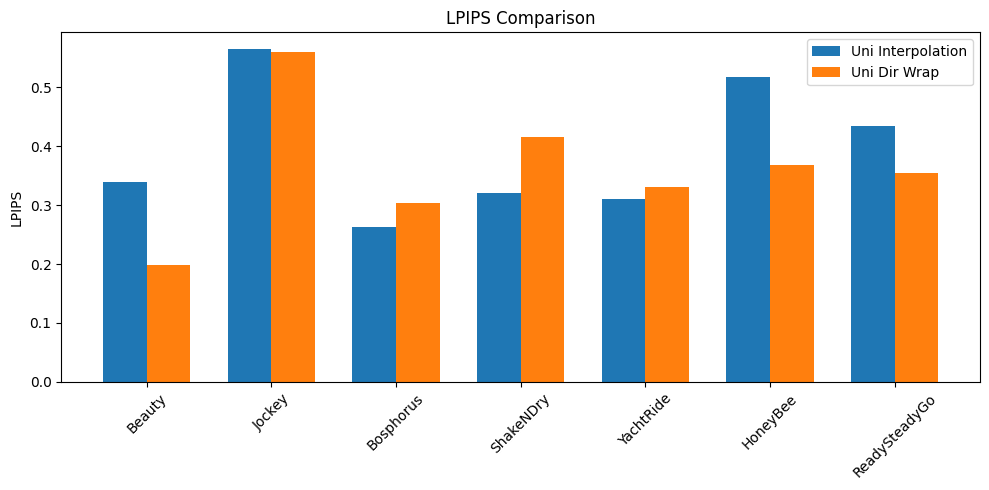

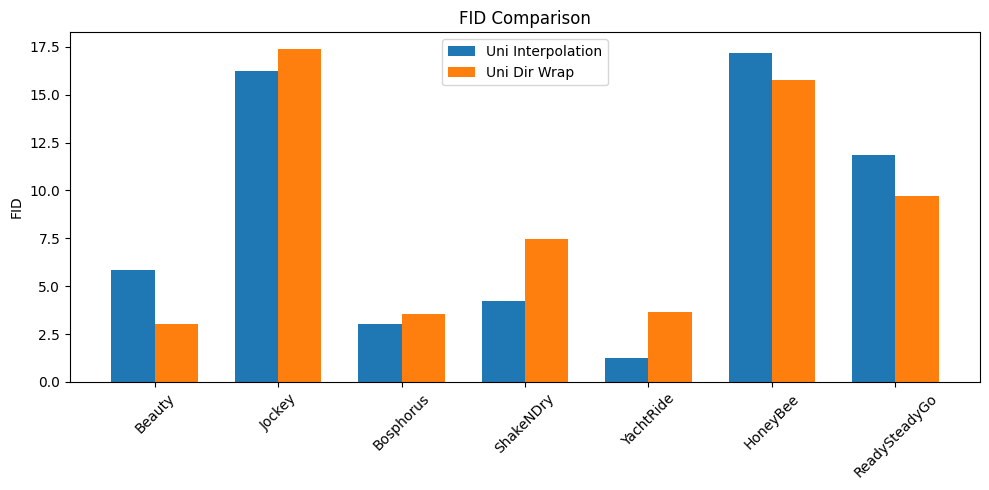

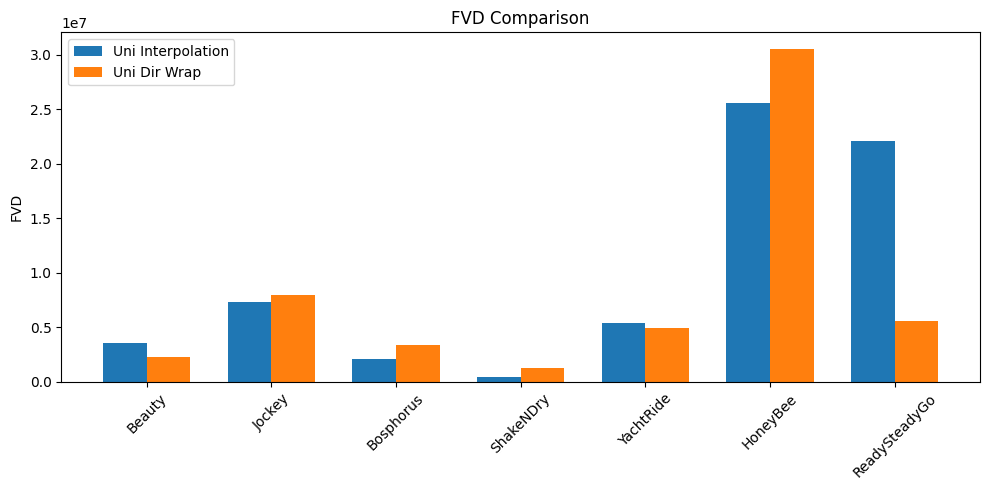

In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load JSON data
def json_load(path):
    with open(path, 'r') as f:
        return json.load(f)

# Paths to the JSON files
uni_in_path = 'experiments/uni_interpolation/preds_25k/all_videos_metrics_8_q4.json'
uni_wrap_path = 'experiments/uni_dir_wrap/preds_25k/all_videos_metrics_8_q4.json'

# Convert to DataFrames
df_in = pd.DataFrame.from_dict(json_load(uni_in_path), orient='index')
df_wrap = pd.DataFrame.from_dict(json_load(uni_wrap_path), orient='index')

# Metrics to plot
metrics = ['PSNR', 'MS-SSIM', 'LPIPS', 'FID', 'FVD']
labels = df_in.index.tolist()  # video names
x = np.arange(len(labels))     # x locations for videos
width = 0.35                   # width of each bar

# Plot each metric separately
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, df_in[metric], width, label='Uni Interpolation')
    ax.bar(x + width/2, df_wrap[metric], width, label='Uni Dir Wrap')

    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{metric}_comparison_wrap.png')  # Optional: save the plots
    plt.show()


In [13]:
avg_in

PSNR       1.887543e+01
MS-SSIM    4.677061e-01
LPIPS      3.931848e-01
FID        8.523136e+00
FVD        9.509317e+06
dtype: float64

In [14]:
avg_wrap

PSNR       1.953758e+01
MS-SSIM    5.540122e-01
LPIPS      3.619941e-01
FID        8.651063e+00
FVD        8.005045e+06
dtype: float64

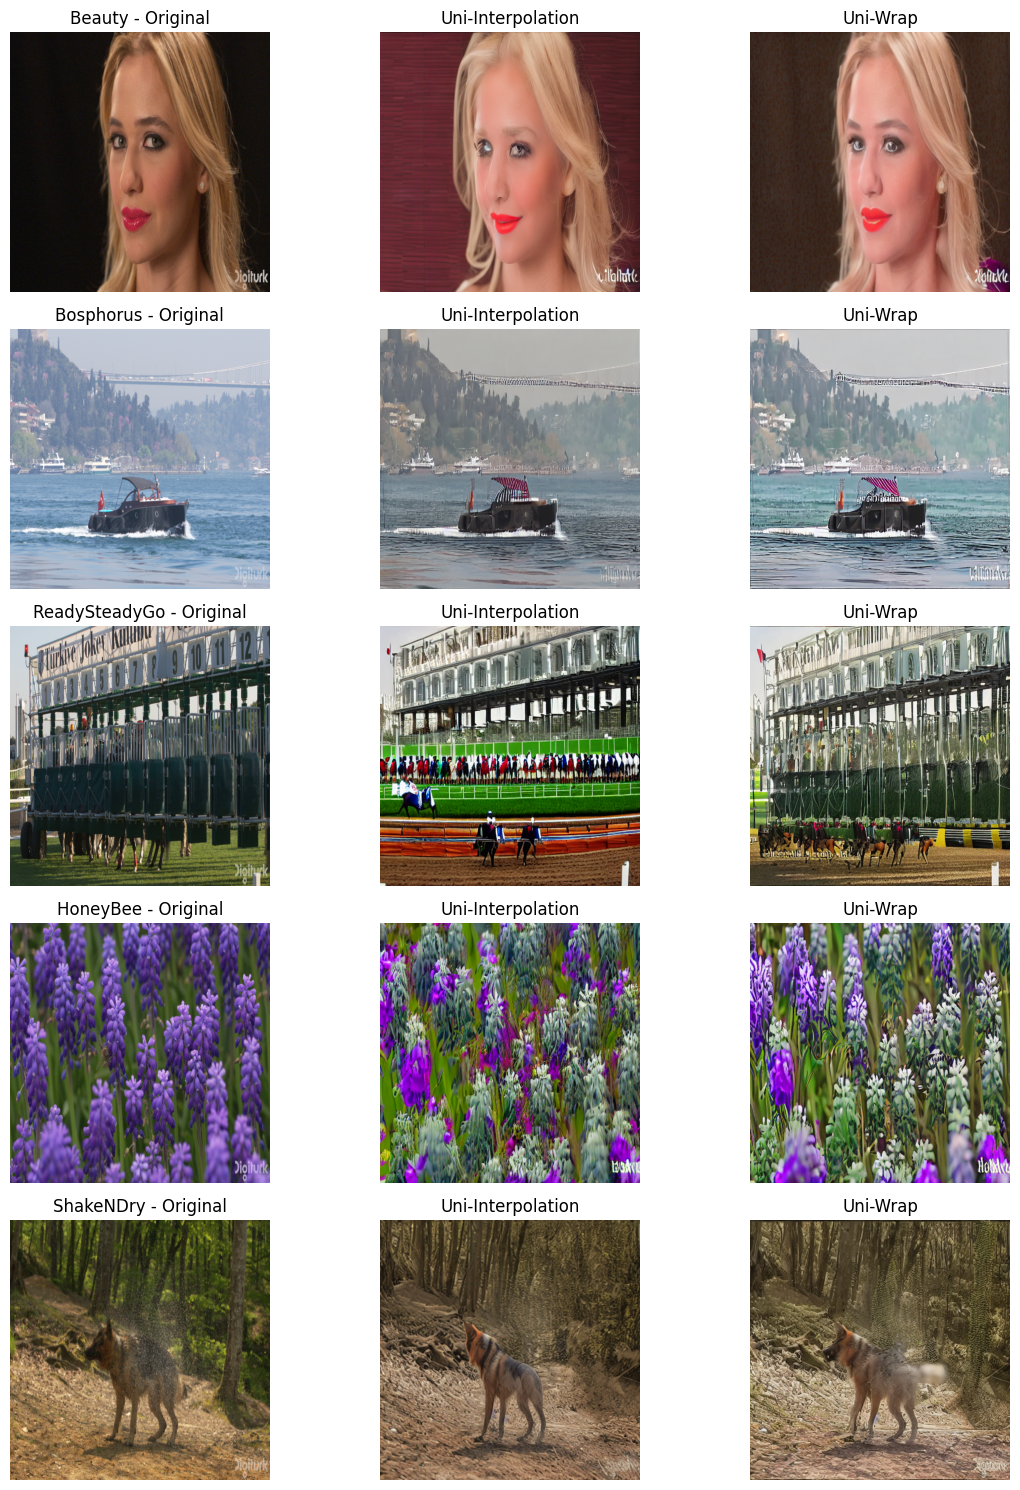

In [4]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Base paths
uni_inter_path = Path('experiments/uni_interpolation/preds_25k/')
uni_wrap_path = Path('experiments/uni_dir_wrap/preds_25k/')
original_path = Path('../Ultra_Perceptual_Video_Compression/data/UVG/')

# Video list
videos = ['Beauty', 'Bosphorus', 'ReadySteadyGo', 'HoneyBee', 'ShakeNDry']

# Set up plot
fig, axs = plt.subplots(len(videos), 3, figsize=(12, 3 * len(videos)))

for idx, video in enumerate(videos):
    uni = cv2.imread(str(uni_inter_path / video / 'im00002_pred.png'))
    wrap = cv2.imread(str(uni_wrap_path / video / 'im00002_pred.png'))
    original = cv2.imread(str(original_path / video / 'images' / 'frame_0001.png'))

    # Convert BGR to RGB for plotting
    uni = cv2.cvtColor(uni, cv2.COLOR_BGR2RGB)
    wrap = cv2.cvtColor(wrap, cv2.COLOR_BGR2RGB)
    original = cv2.resize(cv2.cvtColor(original, cv2.COLOR_BGR2RGB),(512,512))

    axs[idx, 0].imshow(original)
    axs[idx, 0].set_title(f"{video} - Original")
    axs[idx, 1].imshow(uni)
    axs[idx, 1].set_title("Uni-Interpolation")
    axs[idx, 2].imshow(wrap)
    axs[idx, 2].set_title("Uni-Wrap")

    for ax in axs[idx]:
        ax.axis('off')

plt.tight_layout()
plt.show()
